## Projeto 3 - Machine Learning

Caio Emanuel Rhoden - RA 214129

A ideia inicial era tentar fazer um Programa Genético para buscar os resultados do pacman, para isso tentei fazer um programa baseado em um cromossomo com uma PriorityQueue, estrutura de dados vindas na engine do jogo, que definiria a ordem das ações para diferentes situações de jogo (comida ao lado, comida próxima e em zona de perigo), com um array definindo a ordem de priridade do que se olhar primeiro.

Todavia apesar de existir progresso o algoritmo não convergia, até tinha progresso em resultados mas chegava em um certo numero de gerações que ele não tinha mais evolução. Foi aplicada uma série de modificações, como a adição de um status voltado para a capsulas, ainda assim não adiantou muito. Tendo em visto o baixo progresso foi necessário pivotar a ideia e "mudar" um pouco a regra de como o programa funcionava

A partir da leitura dos artigos sugeridos e interação com alguns colegas pareceu fazer sentido dar um passa para trás, simplificando a estrutura mas buscando manter ainda o que era pretendido: comer comida quando tiver ao lado, buscar a comida mais próxima quando nçao tiver nenhuma e não morrer para os fantasmas. Tendo em vista esse objetivo a melhor opção pareceu ser mudar para um algoritmo genético e regrar menos o agente

In [1]:
from pacman2 import runGames,readCommand
from game import Agent, Directions
from util import manhattanDistance, PriorityQueue
import random
import statistics
import matplotlib.pyplot as plt
import operator

### Sumário

### Cromossomo

A estrutura de cromossomo é bem simples, um array composto por 4 valores que representam
as respectivas ações:
- Comer comida próxima
- Se aproximar da comida
- Fantasma próximo
- Se aproximar de fantasma

Eles são criados a aprtir da função abaixo, que retorna um vetor com 4 valores variando de -10 a 10

In [2]:
def create_random_chromossome():
    
    #array created to stablish the six states that will define the actions:
    # - has food
    # - get near to food (if not has food in the adjascents)
    # - has ghost
    # - get away from ghost (if not has ghost in the adjascents)
    
    chromossome = [random.randrange(-10, 10) for i in range(4)]
    
    return chromossome

In [3]:
create_random_chromossome()

[-8, 2, -2, 1]

### Agente

O agente é uma representação do que é usado pelo jogo, ele é iniciado com um cromosso e quando ele é chamado para a primeira ação ele retorna o numero de comidas no labirinto

Ele possui o método tomador de ação (getAction) que pega a possição atual do Pacman e as suas possiveis direções, para cada uma dessas direções é verificado se ele se encaixa em cada uma das situações dos valores do cromossomo, caso ele se encaixe, o valor dessa situação é acrescentado para o "valor" da direção, no fim, a direção com o maior valor é a que será tomada

Com isso o objetivo é que o pacman desenvolva um valor alto para se aproximar de comida e um valor baixo para se aproximar de fantasmas

In [4]:
## Define some rules for the pacman agent

class SingleLookAgent(Agent):
    
    ## Recevies the chromosome, the danger distance from ghosts and initialize de total food of the maze
    
    def __init__(self, chromo, index=0):
        super().__init__(index)
        self.chromossome = chromo
        self.foodTotal = 0

    def getAction(self, state):
        if state.getNumFood() > self.foodTotal:
            self.foodTotal = state.getNumFood()
        
        pacman_pos = state.getPacmanPosition()
        legalActions = state.getLegalPacmanActions()
        directionsValues = {}
        
        foodAdjascents = False
        for i in [-1, 1]:
            if state.hasFood(pacman_pos[0]+i, pacman_pos[1]) or state.hasFood(pacman_pos[0], pacman_pos[1]+i):
                foodAdjascents = True
                break
        
        for i in legalActions:
            directionsValues[i] = 0
            if i == "North":
                position = (pacman_pos[0], pacman_pos[1]+1)
            elif i == "South":
                position = (pacman_pos[0], pacman_pos[1]-1)
            elif i == "West":
                position = (pacman_pos[0]-1, pacman_pos[1])
            elif i == "East":
                position = (pacman_pos[0]+1, pacman_pos[1])
            else:
                position = (pacman_pos[0], pacman_pos[1])
            
            #first coeficient
            if state.hasFood(position[0], position[1]):
                directionsValues[i] += self.chromossome[0]
            
            #second coeficient
            elif not foodAdjascents and len(state.getFood().asList()) > 0:
                
                currentDistFood = min([manhattanDistance(pacman_pos , j) for j in state.getFood().asList()])
                directionDistFood = min([manhattanDistance(position , j) for j in state.getFood().asList()])
                
                if directionDistFood < currentDistFood:
                    directionsValues[i] += self.chromossome[1]
            
            #third coeficient
            if position in state.getGhostPositions():
                 directionsValues[i] += self.chromossome[2]
            
            #fourth coeficient
            else:
                currentDistGhost = min([manhattanDistance(pacman_pos , j) for j in state.getGhostPositions()])
                directionDistGhost = min([manhattanDistance(position , j) for j in state.getGhostPositions()])
                
                if directionDistGhost < currentDistGhost:
                    directionsValues[i] += self.chromossome[3]
        
        return max(directionsValues.items(), key=operator.itemgetter(1))[0]
        
            
            
    

In [5]:

agente = SingleLookAgent(create_random_chromossome())
args = readCommand(['-q', '--pacman', 'GreedyAgent', '-l', 'smallClassic','-n', '1'])
args['pacman'] = agente
a = runGames(**args)
print(a)


In [6]:
print(a[0].state.isWin())

False


### Initiate Random Population

Com essa função é criada uma população aleatória (vetor de cromossomos) de tamanho n

In [7]:
def randomPopulation(size):
    population = []
    for i in range(size):
        population.append(create_random_chromossome())
        
    return population

In [8]:
randomPopulation(2)

[[1, 7, -7, 9], [5, 3, -8, -8]]

### Fitness Function

Aqui vamos estabelecer como condição de sucesso para os individuos, inicialmente podemos estabelecer como critério de sucesso a vitória para os tabuleiros, e para avaliar a aptidão dos individuos até lá, a pontuação total obtida. Como o score pode flutuar bastante com a ingestão das capsulas e não havia nada de fácil acesso na engine para lidar com a situação dos fantasmas vulneráveis, foi optado por ter como objetivo a vitória no tabuleiro, indiferente do score, dessa forma a nossa aptidão é medida pela quantidade de comidas ingeridas pelo agente

Por meio da função abaixo, que recebe o total de comidas no tabuleiro -1 (comida sobre onde o pacman iniciou em cima) e o resultado do jogo, no fim para conseguir as comdias ingeridas é feito total do tabuleiro - número de comidas que sobraram ao final do jogo + 1

In [9]:
def fitnessFunction(gamesResult, totalFood):
    gamesScores = [(totalFood - i.state.getNumFood() + 1) for i in gamesResult]
    avgScore = statistics.mean(gamesScores)            
    return(avgScore)

### Seleção

Para seleção aplicaremos o método de roleta, nele quanto maior a aptidão que um individuo conseguiu maior a chance de ser escolhido, mas ele ainda dá espaço para que individuos não tão aptos possam ser escolhidos (algo mais limitado no formato de campeonato), o que é importante para garantir a variabilidade genética

Essa função por si só é relativamente simples, ela pega a quantidade de comidas ingeridas para cada e individuo e a soma total dessa quantidade, cria um vetor em que vai marcando o limite de cada individuo nessa soma e por fim sortei aleatoriamente um valor entre 1 e a soma acumulado, e o individuo que tiver nessa marcação será adicionado a um vetor de selecionados

In [10]:
def selection(layout, population, n, n_games):
    selected = []
    popScores = []
    for i in range(len(population)):
        agente =  SingleLookAgent(population[i])
        args = readCommand(['-q', '--pacman', 'Agent', '-g', 'DirectionalGhost','-l', layout,'-n', str(n_games)])
        args['pacman'] = agente
        popScores.append(runGames(**args))
    acumulatedScores = []
    fitnessScores = [fitnessFunction(i, args['pacman'].foodTotal) for i in popScores]
    for i in range(len(popScores)):
        if i == 0:
            acumulatedScores.append(fitnessFunction(popScores[i], args['pacman'].foodTotal))
        else:
            acumulatedScores.append(fitnessFunction(popScores[i], args['pacman'].foodTotal)+acumulatedScores[-1])
    
    totalScore = sum(fitnessScores)
    for i in range(n):
        rand = random.randrange(1,int(totalScore))
        for j in range(0, len(fitnessScores)):
            if rand <= acumulatedScores[j]:
                selected.append(population[j])
                break
        
    return selected, popScores, fitnessScores

In [19]:
pop = randomPopulation(3)
print(pop)
selection('smallClassic',pop,1, 3)

[[8, -5, -6, 0], [1, -6, -3, -2], [-9, 9, 3, -2]]


([[8, -5, -6, 0]],
 [[<game.Game at 0x28aff6fa730>,
 [7, 18.666666666666668, 1])

### Crossover

No crossover é onde vamos utilizar os individuos selecionados anteriormente, essa função vai receber os pais (individuos selecionados), a taxa de crossover (quantos % da nova geração será por crossover) e o tamanho da nova geração. A % que não se encaixar como crossover vai ser apenas uma duplicação dos pais.

Para realizar o crossover são selecionados dois cromossomos pais aleatoriamente, depois são selecionadas dois indices de sepração, o primeiro entre 0 e 2, e o segundo entre o primeiro e 3. Dessa forma o novo cromossomo vai ser formado por três segmentos, o primeiro e o terceiro vindo do primeiro pai (menor ou igual ao primeiro indice e maior que o segundo indice), e o segundo do segundo pai (entre o primeiro e segundo indice)

In [22]:
def reproduction(parents, rate, newGenSize):
    newGen = []   
    for j in range(int(rate*newGenSize)//1):
        
        
        p1 = random.randrange(len(parents))
        p2 = p1
        while p2 == p1:
            p2 = random.randrange(len(parents))
        
        parent1 = parents[p1]
        parent2 = parents[p2]
        
        sep1 = random.randrange(0, 2)
        sep2 = random.randrange(sep1+1, 3)
        
        
        new_gene = create_random_chromossome()
        
        for i in range(4):
            if i <= sep1:
                new_gene[i] = parent1[i]
            elif i > sep1 and i <= sep2:
                new_gene[i] = parent2[i]
            else:
                new_gene[i] = parent1[i]
        
        newGen.append(new_gene)
    
    
    for i in range(newGenSize - int((rate*newGenSize)//1)):
        newGen.append(parents[random.randrange(len(parents))])
    
    return newGen
    

In [23]:
example = randomPopulation(2)
print(example)
print()
print()
print(reproduction(example, 1, 2))

[[8, 6, -8, 2], [2, -9, 5, 0]]


[[8, -9, -8, 2], [2, -9, -8, 0]]


### Mutação

A mutação é um elemento que vai nos garantir também a variabilidade genética entre os membros da nova geração, essa função recebe a população da nova geração e a taxa de mutabilidade

A mutação é feita por um simples swap dentro de um cromossomo, trocando de valor os arrays de prioridades de ação. Isso será feito para a % da população passada pela taxa.

In [24]:
def mutation(population, rate):
    
    population_len = [i for i in range(len(population))]
    mutated = random.sample(population_len, int((rate * len(population))// 1))
    
    
    for i in mutated:
        mut_1 = random.randrange(4)
        mut_2 = mut_1
        while mut_1 == mut_2:
            mut_2 = random.randrange(4)
        saved = population[i][mut_1]
        population[i][mut_1] = population[i][mut_2]
        population[i][mut_2] = saved

    return population 
        
        

In [25]:
example = randomPopulation(3)
print(example)
print(mutation(example,0.5))

[[-2, -4, -6, 2], [0, 9, 3, -10], [-2, -2, 2, -8]]
[[-2, -4, -6, 2], [0, 9, 3, -10], [-2, -8, 2, -2]]


### Treinamento

In [16]:
def train(layout, maxGen=1, populationSize=1, selectionSize=1, newGenSize=1,  mutationRate=0.05, 
          crossoverRate=1, n_games=1):
    avgFitnessScores = []
    maxFitnessScores = []
    avgPacmanScores = []
    population = randomPopulation(populationSize)
    for i in range(maxGen):
        pacmanScores = []
        newPopulation = []
        parents, gamesResult, scores = selection(layout, population, selectionSize, n_games)
        newGen = reproduction(parents, crossoverRate, newGenSize)
        cutOffScore = sorted(scores)[populationSize-newGenSize]
        for i in range(populationSize):
            if scores[i] < cutOffScore:
                newGene = newGen.pop()
                newPopulation.append(newGene)
            else:
                newPopulation.append(population[i])
        for g in gamesResult:
            for j in g:
                pacmanScores.append(j.state.getScore())
        maxFitnessScores.append(max(scores))
        avgFitnessScores.append(statistics.mean(scores))
        avgPacmanScores.append(statistics.mean(pacmanScores))
        population = mutation(newPopulation, mutationRate)
        
    
    best_ind = population[scores.index(max(scores))]
    f, axarr = plt.subplots(1,3)
    axarr[0].plot(avgFitnessScores)
    #axarr[0].set_xscale('log')
    axarr[1].plot(maxFitnessScores)
    #axarr[1].set_xscale('log')
    axarr[2].plot(avgPacmanScores)
    #axarr[2].set_xscale('log')
    f.set_size_inches(18, 5)
    plt.show()    
        
    print(f"Best Score Gen {i}: {max(scores)}")
    return population, best_ind
                

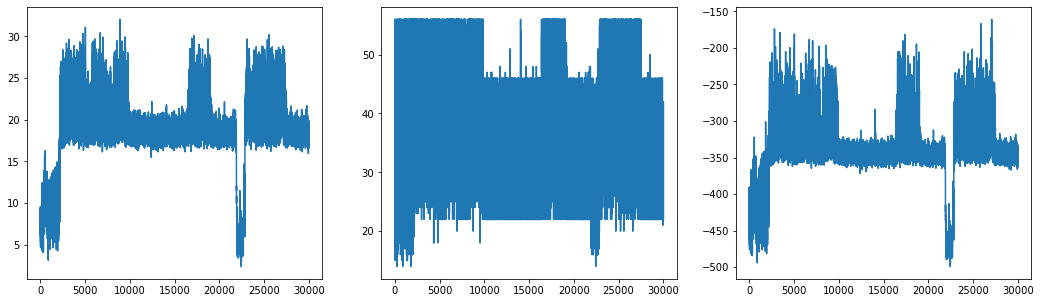

Best Score Gen 19: 22


In [17]:
pop, best_ind = train('smallClassic',maxGen=30000, populationSize=20, selectionSize=3, newGenSize=18)

In [18]:
#graphic show
best_agent = SingleLookAgent(best_ind)
args = readCommand(['--pacman', 'GreedyAgent','-l', 'smallClassic','-n', '1'])
args['pacman'] = best_agent
runGames(**args)

### Treinamento -  Small Classic

Primeiramente vamos fazer o treinamento para o labirinto pequeno, incialmente vamos ver o comprotamento para 100 gerações para cada um dos métodos de  replacement

### Treinamento -  Medium Classic

### Treinamento -  Original Classic

### Avaliação Genetic Programming

#### 